# Traffic Data Analysis

This is a preliminary analysis of traffic crash data made available at 
https://opendata-nzta.opendata.arcgis.com/datasets/crash-analysis-system-cas-data-1/explore?location=-9.510847%2C0.000000%2C2.92

Note that this dataset is not static, therefore its contents may have changed since the time it was downloaded for the purpose of this analysis.

The goal is to
- Characterize the dataset.
- Discern basic trends concerning crash metrics contained in the dataset.


In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Define function to determine basic statistics for the dataframe columns, 
def get_dataset_stats(df, exclude=["excluded_col_1","excluded_col_2"], round_digits=3):
    """
    PARAMETERS:
        df - A dataframe
        exclude - a list of columns names within df to exclude from the analysis
    RETURNS: a dataframe with basic statistics for each column in df, including counts of null values
    """

    # Create list of columns to analyze.
    include_columns = list(df.columns)
    for element in exclude:
        if element in include_columns:
            include_columns.remove(element)
    
    
    types_df = pd.DataFrame(df[include_columns].dtypes).rename({0:"dtype"}, axis=1)
    obj_list = df[include_columns].select_dtypes(include=['object']).columns.to_list()
    # local function to resolve atomic datatypes for 'object' columns:
    def get_obj_type(df, var):
        type = ""
        if df[var].isnull().all():
            type = 'none'
        else:
            try:
                df[var].astype("datetime64[ns]")
                type = 'datetime64[ns]'
            except:
                try:
                    df[var].astype("int64")
                    type = 'int64'
                except:
                    try:
                        df[var].astype("float64")
                        type = 'float64'  
                    except:
                        try:
                            df[var].astype("str")
                            type = 'str'
                        except:
                            type = 'str'
                            pass
        return type    
    
    for col in obj_list:
        new_type = get_obj_type(df, col)
        print("{} new type is {}".format(col, new_type))
        types_df["dtype"][col] = new_type
    
    
    dg = pd.DataFrame(np.nan, index=include_columns, 
                      columns=["type","excluded","non_null_count","nullcnt","%nulls","min",
                               "pcntl25","median","mean","pcntl75","max",
                               "stddev","str-maxlen","str-meanlen","str-medianlen","str-minlen","ndistinct"])
    
    try:
        for varname in include_columns:
            if str(types_df["dtype"][varname]) in ["datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]"]:
                df[varname] = df[varname].dt.tz_localize(None)
                types_df["dtype"][varname] = "datetime64[ns]"
                
            dg.type.loc[varname] = types_df.loc[varname, "dtype"]
            if dg.type.loc[varname] == 'float64':
                df[varname] = df[varname].astype('float')
            elif dg.type.loc[varname] == 'int64':
                df[varname] = df[varname].astype('int')
            if varname in exclude:
                dg.loc[varname,"excluded"] = 'Yes'
            else:
                dg.loc[varname,"excluded"] = 'No'
            # print("Var: {}  Type: {}".format(varname, dg.type.loc[varname]))
            dg.loc[varname,"ndistinct"] = df[varname].nunique()

            if types_df["dtype"][varname] in ["float64","int64","int32","datetime64[ns]","str","none"]:
                dg.loc[varname, "nullcnt"] = df[varname].isna().sum().astype(int)
                totalcnt = df[varname].count().astype(int) + dg.loc[varname, "nullcnt"]
                dg.loc[varname,"non_null_count"] = totalcnt - dg.loc[varname, "nullcnt"]
                dg.loc[varname,"%nulls"] = (100.0 * dg.loc[varname,"nullcnt"] / totalcnt).round(decimals=2)
            if types_df["dtype"][varname] in ["datetime64[ns]"]:
                dg.loc[varname,"min"] = df[varname].dropna().min()
                dg.loc[varname,"max"] = df[varname].dropna().max()
                dg.loc[varname,"mean"] = df[varname].dropna().mean()
            elif types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"min"] = round(df[varname].dropna().min(), round_digits)
                dg.loc[varname,"max"] = round(df[varname].dropna().max(), round_digits)
                dg.loc[varname,"mean"] = round(df[varname].dropna().mean(), round_digits)                
            if types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"pcntl25"] = round(df[varname].dropna().quantile(0.25), round_digits)
                dg.loc[varname,"median"] = round(df[varname].dropna().quantile(0.5), round_digits) 
                dg.loc[varname,"pcntl75"] = round(df[varname].dropna().quantile(0.75), round_digits)
                dg.loc[varname,"stddev"] = round(df[varname].dropna().std(), round_digits)
            if types_df["dtype"][varname] in ["str"] and varname not in exclude:
                dg.loc[varname,"str-maxlen"] = df[varname].str.len().max()
                dg.loc[varname,"str-meanlen"] = df[varname].str.len().mean()
                dg.loc[varname,"str-medianlen"] = df[varname].str.len().median()
                dg.loc[varname,"str-minlen"] = df[varname].str.len().min()
                           
    except:
        print("Failed iteration on variable: {}".format(varname))
    
    return dg

In [43]:
# Define working directories
data_dir = "../data"
output_dir = "../outputs"
os.chdir(data_dir)
#os.getcwd()

In [5]:
## Load data
df = pd.read_csv("Crash_Analysis_System_(CAS)_data.csv")

In [6]:
df.head(60)

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashRoadSideRoad,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,holiday,houseOrBuilding,intersection,kerb,light,meshblockId,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,pedestrian,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,temporarySpeedLimit,tlaId,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1.772561e+06,5.896382e+06,1,NaN,525420.0,0.0,NaN,0.0,1.0,NaN,Null,2007/2008,EAST ST,ELLIOT ST,NaN,Non-Injury Crash,No,2007,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,791600.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,1.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
1,1.836757e+06,5.859311e+06,3,NaN,534300.0,0.0,NaN,0.0,2.0,NaN,Null,2002/2003,SH 2,SH 26,NaN,Non-Injury Crash,Yes,2003,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,1073700.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Waikato Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,12.0,Hauraki District,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Frost
2,1.762088e+06,5.912507e+06,4,NaN,519500.0,0.0,NaN,0.0,1.0,NaN,West,2009/2010,CHURCH ST,HUGO JOHNSTON DRIVE,NaN,Non-Injury Crash,No,2010,NaN,East,NaN,0.0,NaN,Flat,NaN,Queens Birthday,NaN,NaN,NaN,Bright sun,622400.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Off,0.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,0.0,0.0,Urban,1.0,NaN,NaN,Fine,Null
3,1.753522e+06,5.911939e+06,6,NaN,518902.0,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,THE AVENUE,ACCESSWAY,NaN,Minor Crash,No,2017,NaN,North,NaN,0.0,NaN,Hill Road,NaN,NaN,NaN,NaN,NaN,Overcast,587500.0,1.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Null,0.0,0.0,NaN,76.0,Auckland,Nil,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Light rain,Null
4,1.761364e+06,5.914259e+06,7,NaN,520202.0,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,PENROSE INT,GT SOUTH LINK,NaN,Non-Injury Crash,No,2018,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Overcast,612300.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Motorway ramp,1-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Null,0.0,0.0,NaN,76.0,Auckland,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
5,1.803464e+06,5.815043e+06,9,NaN,530500.0,0.0,NaN,0.0,3.0,NaN,North,2009/2010,KNIGHTON ROAD,HELENA ROAD,NaN,Minor Crash,No,2010,NaN,South,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Overcast,891500.0,1.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Waikato Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Off,0.0,0.0,NaN,16.0,Hamilton City,Nil,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
6,1.749964e+06,5.914060e+06,11,NaN,511303.0,0.0,NaN,0.0,1.0,NaN,Null,2013/2014,GREAT NORTH ROAD,MEMORIAL DRIVE,NaN,Non-Injury Crash,No,2014,NaN,South,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,266000.0,0.0,0.0,0.0,4.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,1.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
7,1.572762e+06,5.178572e+06,14,NaN,594200.0,1.0,NaN,0.0,1.0,NaN,Null,2010/2011,ENSORS ROAD,MACKENZIE AVENUE,NaN,Minor Crash,No,2010,NaN,West,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,2581400.0,1.0,0.0,0.0,4.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Canterbury Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,60.0,Christchurch City,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
8

In [7]:
# Obtain basic information: field names, datatypes, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776878 entries, 0 to 776877
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          776878 non-null  float64
 1   Y                          776878 non-null  float64
 2   OBJECTID                   776878 non-null  int64  
 3   advisorySpeed              29289 non-null   float64
 4   areaUnitID                 776762 non-null  float64
 5   bicycle                    776873 non-null  float64
 6   bridge                     310482 non-null  float64
 7   bus                        776873 non-null  float64
 8   carStationWagon            776873 non-null  float64
 9   cliffBank                  310482 non-null  float64
 10  crashDirectionDescription  776878 non-null  object 
 11  crashFinancialYear         776878 non-null  object 
 12  crashLocation1             776878 non-null  object 
 13  crashLocation2             77

In [8]:
# Produce basic statistical report. Determine viable atomic types for those columns of 'object' Dtype.
df_stats = get_dataset_stats(df)


crashDirectionDescription new type is str
crashFinancialYear new type is str
crashLocation1 new type is str
crashLocation2 new type is str
crashSeverity new type is str
crashSHDescription new type is str
directionRoleDescription new type is str
flatHill new type is str
holiday new type is str
light new type is str
region new type is str
roadCharacter new type is str
roadLane new type is str
roadSurface new type is str
streetLight new type is str
tlaName new type is str
trafficControl new type is str
urban new type is str
weatherA new type is str
weatherB new type is str


D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
# Display computed column metrics for dataframe.
df_stats

,type,excluded,non_null_count,nullcnt,%nulls,min,pcntl25,median,mean,pcntl75,max,stddev,str-maxlen,str-meanlen,str-medianlen,str-minlen,ndistinct
X,float64,No,776878.0,0.0,0.00,1150346.0,1704491.50,1757273.000,1720811.722,1792725.00,2465388.404,153587.370,NaN,NaN,NaN,NaN,300896.0
Y,float64,No,776878.0,0.0,0.00,4793921.0,5433734.00,5803817.226,5644636.177,5914008.00,6190095.000,330871.527,NaN,NaN,NaN,NaN,337344.0
OBJECTID,int64,No,776878.0,0.0,0.00,1.0,318535.25,637330.000,637114.897,955793.75,1274097.000,367820.479,NaN,NaN,NaN,NaN,776878.0
advisorySpeed,float64,No,29289.0,747589.0,96.23,10.0,40.00,55.000,54.504,65.00,95.000,18.213,NaN,NaN,NaN,NaN,18.0
areaUnitID,float64,No,776762.0,116.0,0.01,500100.0,519200.00,536630.000,546213.268,573526.00,626801.000,32591.674,NaN,NaN,NaN,NaN,1875.0
bicycle,float64,No,776873.0,5.0,0.00,0.0,0.00,0.000,0.029,0.00,5.000,0.171,NaN,NaN,NaN,NaN,6.0
bridge,float64,No,310482.0,466396.0,60.03,0.0,0.00,0.000,0.014,0.00,4.000,0.118,NaN,NaN,NaN,NaN,5.0
bus,float64,No,776873.0,5.0,0.00,0.0,0.00,0.000,0.016,0.00,3.000,0.127,NaN,NaN,NaN,NaN,4.0
carStationWagon,float64,No,776873.0,5.0,0.00,0.0,1.00,1.000,1.320,2.00,11.000,0.784,NaN,NaN,NaN,NaN,12.0
cliffBank,float64,No,310482.0,466396.0,60.03,0.0,0.00,0.000,0.106,0.00,3.000,0.309,NaN,NaN,NaN,NaN,4.0


In [10]:
# Determine measures that have no non-null values. These could be dropped, since they provide no information, 
# however we will keep them to retain the original frame structure.
df_stats[df_stats["non_null_count"] == 0]

,type,excluded,non_null_count,nullcnt,%nulls,min,pcntl25,median,mean,pcntl75,max,stddev,str-maxlen,str-meanlen,str-medianlen,str-minlen,ndistinct
crashRoadSideRoad,float64,No,0.0,776878.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
intersection,float64,No,0.0,776878.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Find all values for low-cardinality str columns.

(a) Let's check whether the actual value ranges align with those declared in the field descriptions.
    Of special interest will be nulls, NaNs or obvious proxies for these.
    
(b) Some of these features may be candidates for one-hot-encoding if ML is applied on this dataset.

(c) We have arbitrarily set the "low cardinality" threshold to 60, though in practice most string columns of interest have
    fewer distinct values, as can be seen from the column statistics.

In [11]:
distinct_vals = pd.DataFrame(data=None, columns=['Variable', 'Value','Count'])
cardinality_thrsld = 60
for col in df_stats[df_stats.type == 'str'][df_stats.ndistinct < cardinality_thrsld].index.values.tolist():
    for val in df[col].unique():
        if pd.isna(val):
            count = len(df[df[col].isnull()]) # Count the occurrence of NaN values if applicable within this column
        else:
            count = len(df[df[col] == val]) # Count the occurrence of this value within this column
        # Append to dataframe
        distinct_vals.loc[len(distinct_vals)] = [col, val, count]

distinct_vals

<ipython-input-11-19e224c3b594>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for col in df_stats[df_stats.type == 'str'][df_stats.ndistinct < cardinality_thrsld].index.values.tolist():


,Variable,Value,Count
0,crashDirectionDescription,Null,292055
1,crashDirectionDescription,West,95492
2,crashDirectionDescription,North,145423
3,crashDirectionDescription,South,149361
4,crashDirectionDescription,East,94547
5,crashFinancialYear,2007/2008,41119
6,crashFinancialYear,2002/2003,38093
7,crashFinancialYear,2009/2010,37209
8,crashFinancialYear,2017/2018,39583
9,crashFinancialYear,2013/2014,29965


This can aid in decisions about imputing or dropping missing data, where relevant. For example, region shows 3026 cases with value NaN. This may imply either absence of information about the region, or it may imply locations that legitimately lie outside any region. In some contexts it may be valid to treat these as a category; in others to drop these records.
Similar considerations apply to other cases where NaN appears as a value for a categorical variable.

In [12]:
# For the above cases, 'Null' and 'Nil' are probably equivalent. For 'region', NaN might be better recoded 
# to a specific value such as 'Other', since the absence of a region may have some useful meaning. 
# It's not clear that we want to retain data for 'Other' since we will be focusing on defined major regions.
df['region'].fillna('Other',inplace=True)

In [13]:
# Did this work?
len(df[df['region'].isnull()]) # 0 is good.

0

In [14]:
# The one record having NaN value in 'crashSHDescription' is well formed. We ASSUME the value is probably equivalent 
# to 'Unknown'.
df[df['crashSHDescription'].isnull()]

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashRoadSideRoad,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,holiday,houseOrBuilding,intersection,kerb,light,meshblockId,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,pedestrian,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,temporarySpeedLimit,tlaId,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
560970,1.836611e+06,5.866924e+06,920329,NaN,NaN,0.0,0.0,0.0,1.0,0.0,South,2019/2020,026-0070,ROBINSON ROAD,NaN,Serious Crash,NaN,2019,0.0,South,1.0,0.0,0.0,Flat,0.0,NaN,0.0,NaN,0.0,Dark,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,Other,Nil,2-way,Sealed,0.0,0.0,1.0,0.0,100.0,0.0,None,0.0,0.0,NaN,NaN,NaN,Unknown,0.0,0.0,0.0,1.0,0.0,0.0,Open,0.0,0.0,0.0,Fine,Null


In [15]:
df['crashSHDescription'].fillna('Unknown',inplace=True)

In [16]:
len(df[df['crashSHDescription'].isnull()]) # 0 is good.

0

In [17]:
# Similarly for 'directionRoleDescription', NaN is probably equivalent to 'Null'.
df['directionRoleDescription'].fillna('Null',inplace=True)

In [18]:
len(df[df['directionRoleDescription'].isnull()]) # 0 is good.

0

## General observations of dataset

1. The granularity of date / time observations is 1 year (calendar or financial).
   This would preclude detailed time series analysis of (for example) seasonal, weekly, or diurnal effects.
   
2. Depending on the specific subject of analysis, it may be expedient to relate these data to external datasets. Explicit      joins to other geodata may be possible via the coordinates or via the 'crashLocation1' and 'crashLocation2' fields, the    MeshblockID, and the Region.

3. The field descriptions at https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions do not list          'intersection' or 'crashSideRoad'. However, although these columns appear in the crash dataset, they contain no non-null    values.

   Although listed in the field descriptions, 'junctionType' and 'intersectionMidblock' does not appear in the dataset.        
   The 'northing' and 'easting' variables listed in the field descriptions do not appear in the downloaded CSV dataset.
   
   Could it be that these are excluded from the CSV download, but included in geoJson or KML downloads?



### Crash counts by region by year.
For the present purposes we will exclude data without a defined region, i.e. that we have marked as region = 'Other'.

In [126]:
# Create a dataframe that shows the total crashes by year for each region.

crashes_by_region_by_year = pd.DataFrame(
{'region': ['Northland Region','Auckland Region', 'Waikato Region', 'Bay of Plenty Region', 'Gisborne Region',
                'Hawke\'s Bay Region', 'Taranaki Region', 'Manawatū-Whanganui Region',
                'Wellington Region', 'Tasman Region', 'Nelson Region', 'Marlborough Region',
                'West Coast Region', 'Canterbury Region', 'Otago Region', 'Southland Region']})

for i in range(df['crashYear'].min(), df['crashYear'].max()):
    x = pd.DataFrame(df[df['crashYear'] == i]['region'].value_counts().rename(str(i), inplace=True))
    x.reset_index(inplace=True)
    x.rename(columns={"index":"region"}, inplace=True)
    crashes_by_region_by_year = crashes_by_region_by_year.merge(x, how='left', on='region')

crashes_by_region_by_year

,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Northland Region,1015,1120,1236,1552,1540,1450,1543,1630,1560,1550,1441,1224,1216,1193,1265,1366,1501,1670,1841,1670,1547
1,Auckland Region,12285,13670,14811,14445,13426,13588,13763,13887,13548,12866,12753,11259,10865,10686,10640,11442,13308,13787,12631,11788,9839
2,Waikato Region,2749,3638,3465,3652,3678,4170,4307,4282,3909,3826,3770,3548,3226,3041,3134,3549,3989,4688,4692,4477,3923
3,Bay of Plenty Region,1336,1741,1951,2267,2143,2281,2296,2314,2096,2208,2081,1942,1630,1633,1564,1799,2267,2296,2366,2445,2135
4,Gisborne Region,319,435,450,416,450,480,446,423,503,519,506,394,347,363,295,284,362,387,485,466,507
5,Hawke's Bay Region,1236,1318,1435,1565,1643,1730,1611,1844,1554,1562,1502,1249,1029,1045,998,1002,1340,1388,1478,1465,1439
6,Taranaki Region,761,804,839,784,755,810,841,995,965,923,856,805,716,670,602,675,742,779,839,844,819
7,Manawatū-Whanganui Region,1984,2038,2237,2067,1997,2087,2047,1972,1901,1806,2027,1917,1717,1644,1671,1828,1900,2188,2210,2209,2163
8,Wellington Region,3197,3225,3218,3063,3374,3455,4037,4881,4488,4114,3827,2852,2731,2968,2745,2919,3617,3956,3835,3656,3210
9,Tasman Region,296,295,321,385,349,289,310,374,349,338,297,310,263,290,213,259,359,449,390,375,343


#### Plot total crashes by region by year

### Create a frame including crash data by region for each year

### Population by region based on the 2018 Census
These population counts by region from the 2018 Census were sourced from
https://www.stats.govt.nz/tools/2018-census-place-summaries/?gclid=EAIaIQobChMI8Pb9wbOK9wIV7ZNmAh3KMgDxEAAYASAAEgIgqfD_BwE.
The population of 'Other' is assumed to be zero.

In [127]:
pop_by_region_2018 = {
    'region' : ['Northland Region','Auckland Region', 'Waikato Region', 'Bay of Plenty Region', 'Gisborne Region',
                'Hawke\'s Bay Region', 'Taranaki Region', 'Manawatū-Whanganui Region',
                'Wellington Region', 'Tasman Region', 'Nelson Region', 'Marlborough Region',
                'West Coast Region', 'Canterbury Region', 'Otago Region', 'Southland Region'],
    'population_2018' : [179076, 1571718, 458202, 308499, 47517, 
                    166368, 117561, 238797, 
                    506814, 52389, 50880, 47340,
                    31575, 599694, 225186, 97467]
}

pop_df = pd.DataFrame(pop_by_region_2018)
# Rescale the population counts to 1000's and round to 2 significant digits
pop_df['population_2018'] = pop_df['population_2018'].div(1000).round(2)
pop_df.head()

,region,population_2018
0,Northland Region,179.08
1,Auckland Region,1571.72
2,Waikato Region,458.20
3,Bay of Plenty Region,308.50
4,Gisborne Region,47.52


In [130]:
crashes_by_region_2018 = pd.DataFrame(df[df['crashYear'] == 2018]['region'].value_counts().rename("crash_count_2018", inplace=True))
crashes_by_region_2018.reset_index(inplace=True)
crashes_by_region_2018.rename(columns={"index":"region"}, inplace=True)
crashes_by_region_2018.head(16)

,region,crash_count_2018
0,Auckland Region,12631
1,Waikato Region,4692
2,Wellington Region,3835
3,Canterbury Region,3551
4,Bay of Plenty Region,2366
5,Manawatū-Whanganui Region,2210
6,Otago Region,1979
7,Northland Region,1841
8,Hawke's Bay Region,1478
9,Taranaki Region,839


In [133]:
dg = pd.merge(left=crashes_by_region_2018, right=pop_df, on='region', how='inner')
#dg = pd.merge(left=dg, right=pop_df, on='region', how='inner')
dg.sort_values(by='population_2018', ascending=False, inplace=True)

# Determine the ratio of crashes to population.
dg['crash_to_pop_ratio'] = (dg['crash_count_2018'] / dg['population_2018']).round(2)
dg.head()

,region,crash_count_2018,population_2018,crash_to_pop_ratio
0,Auckland Region,12631,1571.72,8.04
3,Canterbury Region,3551,599.69,5.92
2,Wellington Region,3835,506.81,7.57
1,Waikato Region,4692,458.20,10.24
4,Bay of Plenty Region,2366,308.50,7.67


In [134]:
# What is the average crash_to_pop_ratio?
print("The mean crash-to-population-ratio among all regions is {}".format(dg['crash_to_pop_ratio'].mean()))

The mean crash-to-population-ratio among all regions is 8.643125


Create a normalized variant of this ratio, to make for easier recognition of where each region lies on the distribution.

In [135]:
crash_to_pop_array = np.array(dg['crash_to_pop_ratio']).reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(crash_to_pop_array)
std_crash_to_pop_array = scaler.transform(crash_to_pop_array)

dg['std_crash_to_pop_array'] = std_crash_to_pop_array
dg.head()

,region,crash_count_2018,population_2018,crash_to_pop_ratio,std_crash_to_pop_array
0,Auckland Region,12631,1571.72,8.04,-0.407586
3,Canterbury Region,3551,599.69,5.92,-1.840261
2,Wellington Region,3835,506.81,7.57,-0.725207
1,Waikato Region,4692,458.20,10.24,1.079152
4,Bay of Plenty Region,2366,308.50,7.67,-0.657628


### Compare crash counts by region with population

In [137]:
# Reorder the data by descending crash counts.
dg.sort_values(by='crash_count_2018', ascending=False, inplace=True)

[Text(0.5, 0, 'Count of Crashes in 2018'), Text(0, 0.5, 'Region')]

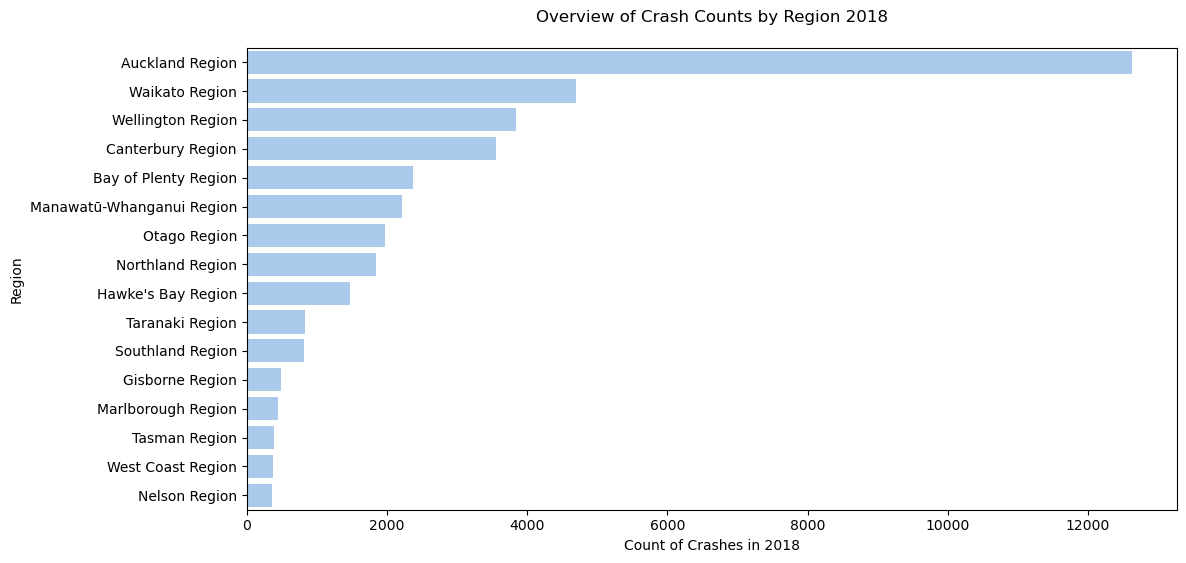

In [138]:
mpl.rc_file_defaults()
#mpl.rcParams['agg.path.chunksize'] = 10000
#sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = dg, x='crash_count_2018', y='region', 
            ci=None, ax=ax1, color='b').set_title('Overview of Crash Counts by Region 2018\n')
ax1.set(xlabel='Count of Crashes in 2018', ylabel='Region')

#ax2 = ax1.twiny()
#sns.lineplot(data = dg[['population_2018','region']], x='population_2018', y='region', marker='o', sort = False, ax=ax2, color='r')
#ax2.set(xlabel='Regional Population from 2018 Census (Thousands)')


As expected, the Auckland region dominates the absolute crash count.
Now let's compare regions on the basis of crashes per unit of population. There are obviously many reasons why this could yield a different result.
Because we have summarized poulation data by region only from the 2018 Census, we will use only the crash data from this year, acknowledging that the results may well be time-variant.

In [139]:
# Reorder the dataframe so that regions with highest crash ratio appear at the top.
dg.sort_values(by='crash_to_pop_ratio', ascending=False, inplace=True)

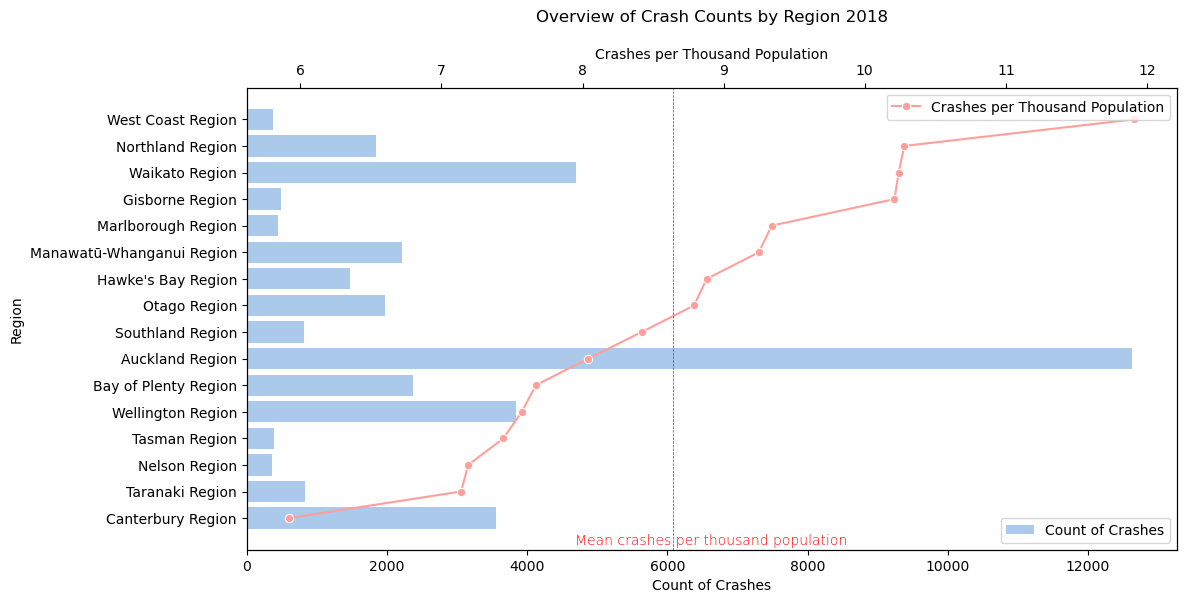

In [141]:
sns.set_color_codes("pastel")
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = dg, x='crash_count_2018', y='region', 
            ci=None, ax=ax1, color='b').set_title('Overview of Crash Counts by Region 2018\n')
ax1.set(xlabel='Count of Crashes', ylabel='Region')
ax1.legend(labels=['Count of Crashes'], loc=4)

ax2 = ax1.twiny()
sns.lineplot(data = dg[['crash_to_pop_ratio','region']], x='crash_to_pop_ratio', y='region', marker='o', sort = False, ax=ax2, color='r')
ax2.set(xlabel='Crashes per Thousand Population')
ax2.legend(labels=['Crashes per Thousand Population'], loc=1)

ax2.axvline(x=dg['crash_to_pop_ratio'].mean(), color='red', ls='--', lw=0.5)
ax2.text(7.95, 16, "Mean crashes per thousand population", 
         horizontalalignment='left', size='medium', color='red', weight='light')

plt.show()

## Observations
The purpose of this display is to assess visually whether the total number of reported crashes by region is broadly consistent with population. We focus here only on the 2018 crash data to ensure consistency. The graph shows the regions in decreasing order of the ratio of crashes to regional population.

- The std_crash_to_pop_array indicates that in 2018, the West Coast was somewhat an outlier in respect of the crash rates by population. Northland, Waikato, and Gisborne had rather higher than average rates.

- By contrast, Canterbury exhibited a lower than average rate. And despite dominating the crash statistics in absolute terms, Auckland's crash rates relative to population size were below average.

- The significance of this metric may be questionable for regions with relatively low crash and / or population counts.

Speculations: perhaps 






The volumes of crashes by region is probably broadly proportional to the regional population. Let's demonstrate this, assuming that the population distribution across the regions has remained roughly consistent over time. (A precise analysis is not intended here.) 

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
#plotting a hitogram with a logarithmic scale
sns.histplot(crashes_by_region, log_scale=True)

It might be instructive to analyze down to Area Units. (AUs) The AU names could be substituted by 
joining to an appropriate Department of Statistics dataset containing the names. However, these values have not remained static over the lifetime of this crash dataset, and have been replaced (since 2018) by SA2s, which are not necessarily geographically consistent with AUs, and do not have the same identifier codes. This entails complications that are best avoided for the present exercise.

In [ ]:
crashes_by_au = df['areaUnitID'].value_counts()
crashes_by_au

In [ ]:
plt.plot(df['crashYear'], df['minorInjuryCount'], 'ro', linestyle="None")
plt.xlabel("Year")
plt.ylabel("Count of Minor Injuries")
plt.title("XXX")
fig1 = plt.gcf()
plt.show()  # show first chart
plt.draw()
fig1.savefig("../outputs/frst_pic.png", dpi=100)

In [ ]:
import seaborn as sns

## Univariate histograms

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", multiple="stack")

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", element="step")

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", element="poly")

## Bivariate histograms

In [ ]:
sns.histplot(df, x="crashYear", y="crashSeverity", color = "yellow")

In [ ]:
sns.histplot(
    df, x="crashYear", y="crashSeverity",
    bins=30, discrete=(True, False),
    cbar=True, cbar_kws=dict(shrink=.75),color="red"
)

In [ ]:
sns.histplot(data=df, x="crashYear", hue="crashSeverity", multiple="dodge", shrink=.9, binwidth=1)

In [ ]:
sns.histplot(data=df, x="crashYear", hue="region", multiple="dodge", shrink=.9, binwidth=1)

It may be interesting to find the most prominent categorical factors that accompany crashes of differing severity levels. These may vary by region and by year. In principle

Another possible question of interest may be to find the streets or intersections with the most frequent 